# Diffusion Equation

$$\frac{\partial}{\partial t}u(x, t) = D\cdot\frac{\partial^2}{\partial x^2}u(x,t)$$

## Explanation
- $u$ : a vector representing quantities diffusing
    - 0 can be only water and 1 can be only dye, for an example
    - can be 1D, 2D, 3D, etc.
- $D$: a physical value representing properties of the fluid simulated
    - the larger D is, the easier it diffuses
- Also known as heat equation

## Approach
Will take the diffusion equation (continuous in space and time) and approximate it using discrete volumes and discrete times using finite difference methods:
- forward difference:
$$
\Delta_{h}[f](x) = f(x + h) - f(x)
$$
- backward difference:
$$
\nabla_{h}[f](x) = f(x) - f(x-h) = \Delta_{h}[f](x-h)
$$
- central difference:
$$
\delta_{h}[f](x) = f(x+\frac{h}{2}) - f(x-\frac{h}{2}) = \Delta_{h/2}[f](x) + \nabla_{h/2}[f](x)
$$


*Forward Euler method for first order derivative* for LHS
$$
\frac{\partial}{\partial t}u(x, t) \approx \Delta_{dt}[u(x, \cdot)](t) = \frac{u(x, t+dt) - u(x, t)}{dt}
$$

*central Euler method for second order derivative* for RHS
$$
\frac{\partial^2}{\partial x^2}u(x,t) \approx \frac{\delta^2_{dx}[u(\cdot, t)](x)}{dx^2} = \frac{\frac{u(x+dx, t) - u(x, t)}{dx} - \frac{u(x, t) - u(x-dx, t)}{dx}}{dx}
$$
$$
= \frac{u(x+dx, t) - 2 \cdot u(x, t) + u(x-dx, t)}{dx^2}
$$

$\implies$

$$
\frac{u(x, t+dt) - u(x, t)}{dt} \approx D\cdot\frac{u(x+dx, t) - 2 \cdot u(x, t) + u(x-dx, t)}{dx^2}
$$

$\implies$

$$
u(x, t+dt) \approx u(x, t) + dt \cdot D \cdot \frac{u(x+dx, t) - 2 \cdot u(x, t) + u(x-dx, t)}{dx^2}
$$

WLOG we can assume $D=1$ and $dx = 1$

## Considerations
### Boundary Conditions?
"$x-dx$" when $x$ is at the beginning of matrix?
- fixed boundary condition :  any value out of the bounds of the matrix will be set to $C$ (usually 0)
- periodic boundary condition : take $(x-dx) \mod N$ where N is the length of the matrix
### Storage?
- how are we going tp store multiple time components of $u$
- we could have one matrix for every time value we do our calculation for
- two matrices? : one for the current state of the fluid and one for the next state

In [59]:
# pure python code
from math import sqrt
from random import random
from typing import Callable, Iterable, Tuple

# helper functions

def get_random_initial_condition(N: int) -> Iterable[float]:
    if N < 1:
        raise ValueError

    for _ in range(N):
        u_i = random.random()
        yield float(round(u_i))


def iterate_with_fixed_boundaries(
        u: Iterable[float], C: float=0.0) -> Iterable[Tuple[float, float, float]]:
    if not u:
        raise ValueError

    left = right = C
    u = iter(u)
    center = next(u)

    for u_i in u:
        right = u_i
        yield left, center, right

        left = center
        center = right

    right = C
    yield left, center, right


def iterate_with_periodic_boundaries(
        u: Iterable[float]) -> Iterable[Tuple[float, float, float]]:
    u_lst = list(u)
    N = len(u_lst)

    for i in range(N):
        yield u_lst[(i-1)%N], u_lst[i%N], u_lst[(i+1)%N]


def generate_updates(
        u: Iterable[float],
        D: float,
        dt: float,
        iterate: Callable[[Iterable[float]], Iterable[Tuple[float, float, float]]]) -> Iterable:
    #inner_product = 0.0

    for u_left, u_center, u_right in iterate(u):
       u_new = u_center + dt * D * (u_left - 2*u_center + u_right)
       #inner_product += (u_new-u_center) ** 2
       yield u_new

    #yield sqrt(inner_product)


def one_dimension_diffusion(
        N: int, T: int,
        initial_condition=get_random_initial_condition,
        iterate=iterate_with_periodic_boundaries,
        B=0.00001, D=1.0, dt=0.0001) -> Iterable[float]:
    u = initial_condition(N)

    for _ in range(T):
        #print(f'Current time is: {t}')
        u = list(generate_updates(u, D, dt, iterate))
        #norm = u.pop()
        #if norm < B:
        #    break

    return list(u)


/home/dan-seol/micromamba/envs/cpy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dan-seol/micromamba/envs/cpy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dan-seol/micromamba/envs/cpy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dan-seol/micromamba/envs/cpy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

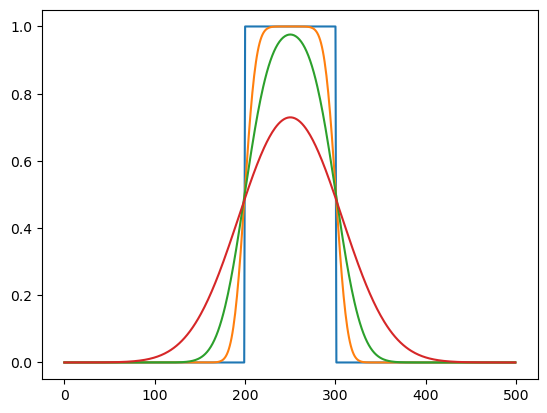

In [63]:
import seaborn as sns

N = 500


def get_top_hat_initial_condition(N, left=200, right=300):
    for i in range(N):
        yield 1.0 if left <= i <= right else 0.0


for T in (0, 500, 2500, 10500):
    u = one_dimension_diffusion(
        N, T, initial_condition=get_top_hat_initial_condition, D=2, dt=0.05)
    sns.lineplot(data=u)

# Multidimensional Diffusion Equation

$$
\frac{\partial}{\partial t}u(\vec{x}, t) = D * \nabla^2 u = \sum_{i=1}^n\frac{\partial^2 u}{\partial x_i^2}(\vec{x}, t)
$$

$\implies$
$$
\frac{u(x, t+dt) - u(x, t)}{dt} \approx 
$$

$$
D\cdot \sum_{i=1}^n\frac{u(x_1, x_2, ..., x_i+dx_i, ..., x_n, t) - 2 \cdot u(\vec{x}, t) + u(x_1, x_2, ..., x_i-dx_i, ..., x_n, t)}{dx_i^2}
$$

$\implies$

$$
u(x, t+dt) \approx u(x, t) +
$$

$$
dt \cdot D\cdot \sum_{i=1}^n\frac{u(x_1, x_2, ..., x_i+dx_i, ..., x_n, t) - 2 \cdot u(\vec{x}, t) + u(x_1, x_2, ..., x_i-dx_i, ..., x_n, t)}{dx_i^2}
$$


WLOG we can assume $D=1$ and $\forall i$ $ dx_i = 1$

In [66]:
%load_ext memory_profiler

In [68]:
from diffusion_python import run_experiment
%memit run_experiment(500)

peak memory: 338.04 MiB, increment: 8.02 MiB


In [69]:
from diffusion_python_memory import run_experiment
%memit run_experiment(500)

peak memory: 337.05 MiB, increment: 7.00 MiB


In [1]:
import time
import numpy as np

%load_ext line_profiler
%load_ext memory_profiler
